In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad
from scipy.optimize import newton
from scipy.special import binom

In [2]:
A = np.zeros((6,6))
B = np.zeros((6,6))
Bstar = np.zeros((6,6))
A[:,0] = 1.
B[0,0] = 1.
B[1,:2] = np.array([3.,-1.])/2.
B[2,:3] = np.array([23.,-16.,5.])/12.
B[3,:4] = np.array([55.,-59.,37.,-9.])/24.
B[4,:5] = np.array([1901.,-2774.,2616.,-1274.,251.])/720.
B[5,:6] = np.array([4277.,-7923.,9982.,-7298.,2877.,-475.])/1440.
Bstar[0,0] = 1.
Bstar[1,:2] = np.array([1.,1.])/2.
Bstar[2,:3] = np.array([5.,8.,-1.])/12.
Bstar[3,:4] = np.array([9.,19.,-5.,1.])/24.
Bstar[4,:5] = np.array([251.,646.,-264.,106.,-19.])/720.
Bstar[5,:6] = np.array([475.,1427.,-798.,482.,-173.,27.])/1440.

In [53]:
def RK(fun,t_span,y0,h):
    t = np.arange(t_span[0],t_span[1],h)
    n_steps = len(t)
    N = len(y0)
    y = np.zeros((N,n_steps))
    dy = np.zeros((N,n_steps))
    y[:,0] = y0
    dy[:,0] = fun(t[0],y[:,0])
    for i in range(n_steps-1):
        k1 = fun(t[i],y[:,i])
        k2 = fun(t[i]+h/2,y[:,i]+h/2*k1)
        k3 = fun(t[i]+h/2,y[:,i]+h/2*k2)
        k4 = fun(t[i+1],y[:,i]+h*k3)
        y[:,i+1] = y[:,i] + h*(k1+2*k2+2*k3+k4)/6
        dy[:,i+1] = fun(t[i+1],y[:,i+1])
    return t,y,dy

def solver(fun,t_span,y0,h,order):
    t = np.arange(t_span[0],t_span[1],h)
    n_steps = len(t)
    N = len(y0)
    y = np.zeros((N,n_steps))
    dy = np.zeros((N,n_steps))
    t[:order],y[:,:order],dy[:,:order] = RK(fun,[t_span[0],t_span[0]+order*h],y0,h)
    for i in range(order,n_steps):
        y_p = np.zeros(N)
        # predictor
        for j in range(order):
            y_p += A[order-1,j]*y[:,i-1-j] + h*B[order-1,j]*dy[:,i-1-j]
        # corrector
        y_c = A[order-1,0]*y[:,i-1] + h*Bstar[order-1,0]*fun(t[i],y_p)
        for j in range(1,order):
            y_c += A[order-1,j]*y[:,i-j] + h*Bstar[order-1,j]*dy[:,i-j]
        y[:,i] = y_c
        dy[:,i] = fun(t[i],y[:,i])
    return t,y

In [4]:
def vanderpol(t,y,epsilon):
    return np.array([
        y[1],
        epsilon*(1-y[0]**2)*y[1] - y[0]
    ])
def jacobian(t,y,epsilon):
    return np.array([
        [0,1],
        [-2*epsilon*y[0]*y[1]-1,epsilon*(1-y[0]**2)]
    ])

In [29]:
alpha = 1e-3
gamma = 1e-3
L = 0.1
C = 0.1
tau = 1./np.sqrt(L*C)
epsilon = alpha * np.sqrt(L/C)
reltol = 1e-6
abstol = np.array([1e-8,1e-8])
tend = 20.
v0,w0 = 2e-3,0.
y0 = np.array([v0*np.sqrt(3*gamma/alpha),w0*np.sqrt(3*gamma/alpha)])
method = 'BDF'
if method == 'RK45':
    sol = solve_ivp(lambda t,y: vanderpol(t,y,epsilon),[0,tend/np.sqrt(L*C)],y0,
                    method='RK45',atol=abstol,rtol=reltol)
elif method == 'BDF':
    sol = solve_ivp(lambda t,y: vanderpol(t,y,epsilon),[0,tend/np.sqrt(L*C)],y0,
                    method='BDF',jac=lambda tau,y: jacobian(tau,y,epsilon),
                    atol=abstol,rtol=reltol)
T = np.sqrt(L*C) * sol['t']
V = np.sqrt(alpha/(3*gamma)) * sol['y'][0]
W = np.sqrt(alpha/(3*gamma)) * sol['y'][1]

In [51]:
h = 0.1
t,y = solver(lambda t,y: vanderpol(t,y,epsilon),[0,tend/np.sqrt(L*C)],y0,h,order=4)
t *= np.sqrt(L*C)
v = y[0,:] * np.sqrt(alpha/(3*gamma))

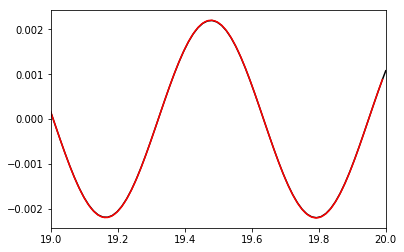

In [52]:
plt.plot(T,V,'k')
plt.plot(t,v,'r')
plt.xlim([19,20])
plt.show()